# <center>Natural Language Processing with Disaster Tweets<center>

O objetivo deste trabalho é apresentar a minha solução para a competição Natural Language Processing with Disaster Tweets.

<p style='text-align: justify;'>A imensa maioria das soluções vencedoras dessa competição utilizam redes neurais, porém nesse trabalho busco apresentar uma solução que atinge bom desempenho utilizando apenas o modelo Multinomial Naive Bayes. Além disso como estratégia para o processamento de texto utilizarei a abordagem Bag of Words (CountVectorizer) que pareceu nos conduzir a melhores resultados do que a abordagem TfidfVectorizer.

Mais informações sobre a competição em https://www.kaggle.com/competitions/nlp-getting-started/overview

In [1]:
# Algumas importações básicas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split , KFold
from sklearn.metrics import f1_score
from IPython.display import Image

## Leitura dos Arquivos de Treino e Teste

In [2]:
train = pd.read_csv('train_tweet.csv')
test = pd.read_csv('test_tweet.csv')

In [3]:
# Dimensões do Dataset de Treino

train.shape

(7613, 5)

In [4]:
# Dimensões do Dataset de Teste

test.shape

(3263, 4)

In [5]:
# Observando as 5 primeiras linhas do Dataset de treino

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Tipos de dados

train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [7]:
# % de Disastres Reais no Dataset de Treino

(train['target'].sum()/train['target'].count())*100

42.96597924602653

In [8]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Em nossa modelagem observamos que incluir as variáveis "keyword" e "location" nos modelos nos traz resultados piores, portanto faremos apenas o pré-processamento da variável "text". Sendo assim não nos preocuparemos em lidar com os valores ausente das variáveis "keyword" e 'location'.

## Pré-processamento de Texto

Criando uma função que recebe uma string e retorna uma string composta apenas por palavras compostas somente por caracteres alfabéticos (letras de "a" a "z"). Além disso essa função aplica a Lemmatização.

In [10]:
nlp = spacy.load('en_core_web_sm')

In [11]:
def text_preprocessing(string):
    doc = nlp(string)
    
    doc2 = " ".join([str(token) for token in doc if str(token).isalpha()])
    
    doc3 = nlp(doc2)
    
    return " ".join([token.lemma_ for token in doc3])

Criando a coluna "pre-processed text" nos datasets de treino e de teste. Essa coluna é resultado do pré-processamento dos textos presentes na coluna "text" através da função text_preprocessing.

In [12]:
train['pre-processed text'] = train['text'].apply(text_preprocessing)

test['pre-processed text'] = test['text'].apply(text_preprocessing)

In [13]:
# Dando uma olhada no resultado do pré-processamento

train[['text' , 'pre-processed text']].head()

,text,pre-processed text
0,Our Deeds are the Reason of this #earthquake M...,our deed be the Reason of this earthquake may ...
1,Forest fire near La Ronge Sask. Canada,forest fire near La Ronge Sask Canada
2,All residents asked to 'shelter in place' are ...,all resident ask to shelter in place be be not...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order in Ca...
4,Just got sent this photo from Ruby #Alaska as ...,just got send this photo from Ruby Alaska as s...


## Validação Cruzada

In [14]:
# Instanciando o modelo Multinomial Naive-Bayes

model = MultinomialNB()      

In [15]:
vectorizer = CountVectorizer(lowercase = True , stop_words = 'english')

In [16]:
X = np.array(train['pre-processed text'])
y = np.array(train['target'])

In [17]:
# Dividindo o Dataset de treino para a validação cruzada

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.3 , stratify = y , random_state = 12)

In [18]:
kf = KFold(n_splits = 10 , shuffle = True , random_state = 451)

In [19]:
# Obtendo a média dos 10 scores de validação cruzada de acordo com a métrica f1

scores = []
for train_index , test_index in kf.split(X):
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        bow_train = vectorizer.fit_transform(X_train)
        bow_test = vectorizer.transform(X_test)
        model.fit(bow_train , y_train)
        pred = model.predict(bow_test)
        scores.append(f1_score(y_test , pred))
np.mean(scores)

0.7463347863068382

<p style='text-align: justify;'>Um score de 74,63 % é um excelente score de validação cruzada. Ao treinarmos nossa Bag of Words em todo o conjunto de treino o vocabulário obtido será maior e ,por isso, a chance de obtermos um resultado melhor quando submetermos ao Kaggle é grande. Vamos ver qual score obtemos no Kaggle ao submetermos as previsões de um modelo Multinomial Naive-Bayes com a configuração padrão do Scikit-Learn :

## Primeira Submissão ao Kaggle

In [20]:
bow_train = vectorizer.fit_transform(X)

bow_test = vectorizer.transform(test['pre-processed text'])

In [21]:
# Treinando MultinomialNB()

model.fit(bow_train , y)

MultinomialNB()

In [22]:
# Previsões

test['target'] = model.predict(bow_test)

In [23]:
test[['id' , 'target']].to_csv('submission1.csv' , index = False)

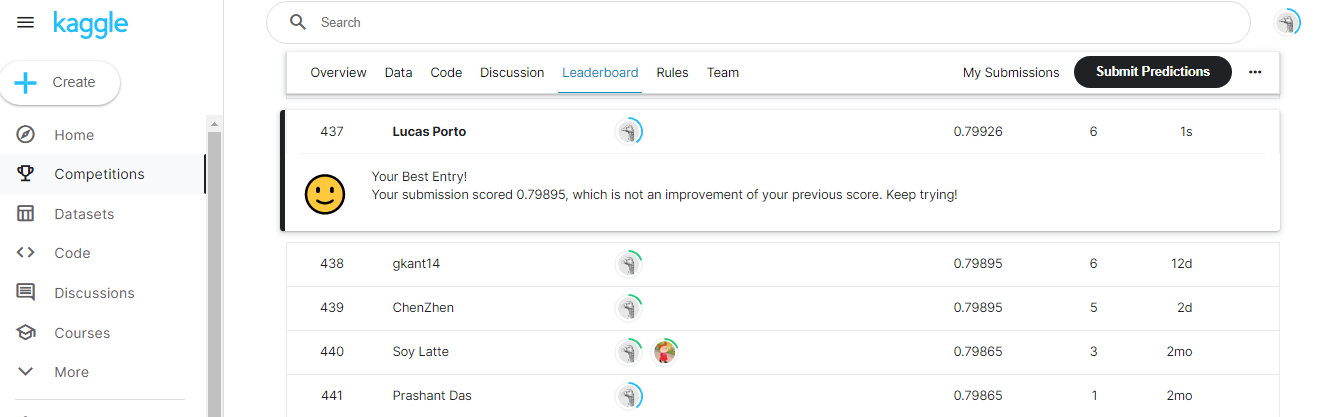

In [24]:
Image('kaggle1.png')

Obtivemos um score de 0.79895 no Kaggle. Para obtermos um score de 0.79926 precisamos otimizar os hiperparâmetros. Vamos ver como fazer isso :

## Otimização dos Hiperparâmetros

In [25]:
# Dividindo o Dataset de treino para a validação cruzada

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.3 , stratify = y , random_state = 12)

In [26]:
kf = KFold(n_splits = 10 , shuffle = True , random_state = 451)

In [27]:
# Observando a média dos scores de validação cruzada para 100 valores distintos do parâmetro alpha

alpha_scores = []
alphas = np.arange(0.1 , 10.1 , 0.1)
for alpha in alphas :
    scores = []
    for train_index , test_index in kf.split(X):
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        bow_train = vectorizer.fit_transform(X_train)
        bow_test = vectorizer.transform(X_test)
        model = MultinomialNB(alpha = alpha)
        model.fit(bow_train , y_train)
        pred = model.predict(bow_test)
        scores.append(f1_score(y_test , pred))
    alpha_scores.append(np.mean(scores))

In [28]:
# Observando os valores de alpha ordenados por  seus respectivos scores médios de validação cruzada

dic = {'Alphas' : alphas , 'Score Médio na Validação Cruzada' : alpha_scores}

df = pd.DataFrame(dic)

df.sort_values(by = ['Score Médio na Validação Cruzada'] , ascending = False)

,Alphas,Score Médio na Validação Cruzada
21,2.2,0.749196
20,2.1,0.749159
19,2.0,0.748813
22,2.3,0.748785
29,3.0,0.748681
...,...,...
99,10.0,0.741990
96,9.7,0.741951
95,9.6,0.741821
94,9.5,0.741821


Os melhores scores obtidos ocorreram para alpha = 2.2 e para alpha = 2.1 . Quando submetemos ao Kaggle o melhor resultado ocorre para alpha = 2.1

## Segunda Submissão ao Kaggle

In [29]:
bow_train = vectorizer.fit_transform(X)

bow_test = vectorizer.transform(test['pre-processed text'])

In [30]:
model = MultinomialNB(alpha = 2.1)

model.fit(bow_train , y)

MultinomialNB(alpha=2.1)

In [31]:
# Previsões

test['target'] = model.predict(bow_test)

In [32]:
test[['id' , 'target']].to_csv('submission2.csv' , index = False)

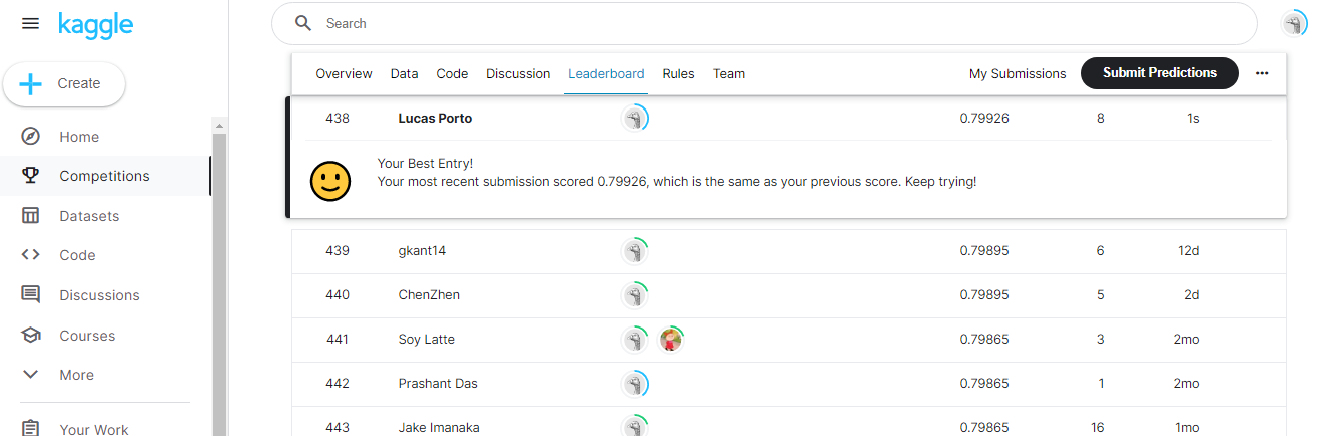

In [33]:
Image('kaggle2.png')

## Comentários Finais

<p style='text-align: justify;'>Espero ter conseguido mostrar uma abordagem simples, porém eficaz ao tratarmos problemas de processamento de texto. É claro que existem outras abordagens que facilmente permitem obter um melhor score, porém a maioria delas utiliza redes neurais. Uma sugestão para aqueles que buscam uma melhor classificação é usar o Google BERT (Bidirectional Encoder Representations from Transformers) . Esse algoritmo de Deep Learning facilmente conduz a um melhor score.